<img src="https://drive.google.com/uc?id=1DvKhAzLtk-Hilu7Le73WAOz2EBR5d41G" width="500"/>

---


### ***Name***: Hanson Shen
### ***username***: edsml-hs1623
### ***CID***: 02463605


You can save this notebook in Colab by clicking `File` from the top menu, and then selecting `Download --> Download .ipynb`

Make sure that when you save your notebook you have all the cells executed and you can see the outputs (livelossplot graphs, etc)

## Hyperparameter tunning notebook

Explain the steps and tests you do.

Organise it well to show how the data you present here has helped you design your final network hyperparameters (that you will use for the final training in the `yourusername_DLcw1_clean.ipynb` notebook).

# Structure Selection (Convolutional layers)
- Linear layers
- Convolutional layers: provide more diverse images


In [ ]:
'''
4 Linear layers

Loss
	D_Loss           	 (min:    0.020, max:    0.414, cur:    0.082)
	G_Loss           	 (min:    2.077, max:    6.929, cur:    6.099)
'''

class Generator(nn.Module):
    def __init__(self, g_input_dim=100, g_output_dim=32*32):
        super().__init__()
        self.fc1 = nn.Linear(g_input_dim, 128)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)

    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))

class Discriminator(nn.Module):
    def __init__(self, d_input_dim=32*32):
        super().__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)

    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [ ]:
'''
Using covolutional layers instead of linear layers, but the model collapsed,
since G_loss is always close to zero

Loss
	D_Loss           	 (min:    0.000, max:    0.491, cur:    0.123)
	G_Loss           	 (min:    2.110, max:   14.101, cur:    4.399)
'''

class Generator(nn.Module):
    def __init__(self, z_dim=100, channels=1, image_size=32):
        super(Generator, self).__init__()
        self.fc = nn.Linear(z_dim, 256 * (image_size // 8) * (image_size // 8))
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = F.relu(self.fc(x))
        x = x.view(x.size(0), 256, (image_size // 8), (image_size // 8))
        x = self.deconv(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, channels=1, image_size=32):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )

        # Adjust the input size of the linear layer based on the output size of the convolutional layers
        self.fc = nn.Linear(256 * (image_size // 8) * (image_size // 8), 1)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc(x))
        return x

image_size = 32
G = Generator(image_size=image_size).to(device)
D = Discriminator(image_size=image_size).to(device)

# Hyper Tuning

###Change the parameters, and run for 10 or 20 epochs to see how the model works

- batch size: 64, 100, 200, 400, 800
- z_dim: 100, 200, 300, 400, 800
- learning rate: 0.0005, 0.0001, 0.00005

- also try differnet structure: ReLU, leaky_relu, dropout

###Conclusion:
1. as batch size, z_dim increase, the plot gets more like what we expected (D_loss starts lower and increases gradually, while G_loss is the opposite, meaning that it is actually learning from each other)
2. smaller learning rate is more accurate, but might caught into local minima
3. replace ReLU with leaky_relu helps producing diverse images (the D_loss isn't always very close to zero)
4. dropout(0.3) doesn't help in my structure
5. I chose bs=800, z_dim=800, lr=0.00005, using leaky_relu for my model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [ ]:
!pip install livelossplot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random', 'Generator']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image

from PIL import Image
import os
import random


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

class XrayDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Get a list of all image filenames in the directory
        self.image_filenames = [filename for filename in os.listdir(root_dir) if filename.endswith(('.jpg', '.jpeg', '.png'))]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_filenames[idx])
        image = Image.open(img_name).convert("L")

        if self.transform:
            image = self.transform(image)

        label = 0  ## assign label to be 0, we don't use this attribute later
        return image, label

# ImageFolder Dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)),  ## Domain knowledge: check the size of the image
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])  # good practice to start from 0.5 and 0.5 in GANs

class Generator(nn.Module):
    def __init__(self, z_dim, channels=1, image_size=32):
        super(Generator, self).__init__()
        self.fc = nn.Linear(z_dim, 256 * (image_size // 8) * (image_size // 8))
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = F.relu(self.fc(x))
        x = x.view(x.size(0), 256, (image_size // 8), (image_size // 8))
        x = self.deconv(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, channels=1, image_size=32):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )

        # Adjust the input size of the linear layer based on the output size of the convolutional layers
        self.fc = nn.Linear(256 * (image_size // 8) * (image_size // 8), 1)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc(x))
        return x

def D_train(x):
    D.train()
    D_optimizer.zero_grad()

    # train discriminator on real data -- assign high score (use 1 here)
    x_real, y_real = x, torch.ones(x.size(0), 1).to(device)  # no need to flatten
    # x_real, y_real = x.view(-1, 32*32), torch.ones(bs, 1)
    # x_real, y_real = x, torch.ones(bs, 1)
    x_real, y_real = x_real.to(device), y_real.to(device)

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)

    # train discriminator on fake data -- assign low score (use 0 here)
    # sample vector and produce generator output
    z = torch.randn(x.size(0), z_dim).to(device)
    x_fake, y_fake = G(z), torch.zeros(x.size(0), 1).to(device)
    # x_fake, y_fake = G(z), torch.zeros(bs, 1).to(device)

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)

    # combine the losses
    D_loss = D_real_loss + D_fake_loss

    # model update
    D_loss.backward()
    D_optimizer.step()

    return  D_loss.data.item()

def G_train(x):
    G.train()
    G_optimizer.zero_grad()

    # sample vector and produce generator output
    z = torch.randn(bs, z_dim).to(device)
    G_output = G(z)

    # obtain scores from D for the generated data
    D_output = D(G_output)

    # train generator to "fool" discriminator
    y = torch.ones(bs, 1).to(device)
    G_loss = criterion(D_output, y)

    # model update
    G_loss.backward()
    G_optimizer.step()

    return G_loss.data.item()

# Start the testing from here

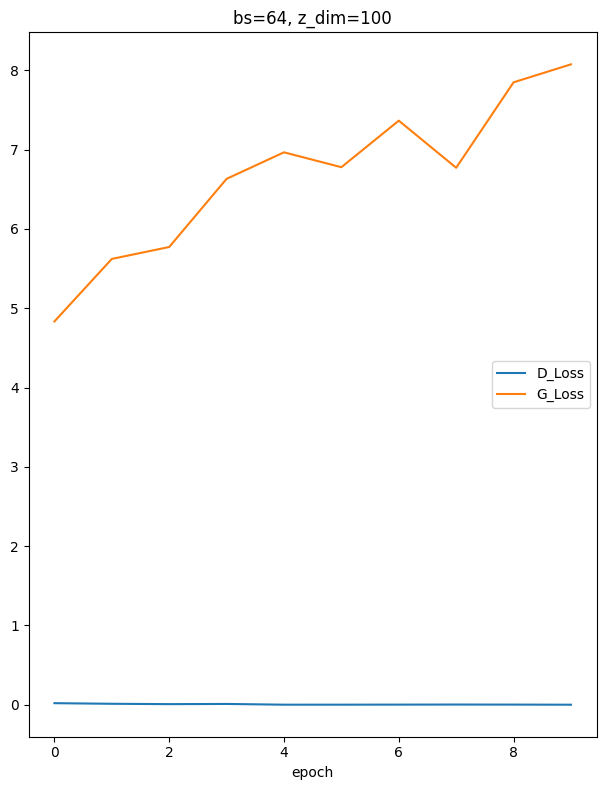

bs=64, z_dim=100
	D_Loss           	 (min:    0.001, max:    0.020, cur:    0.001)
	G_Loss           	 (min:    4.833, max:    8.075, cur:    8.075)


In [ ]:
## COMMENT: strat with default values, bs=64, z_dim=100

# define train data and batch size
bs = 64
train_dataset = XrayDataset(root_dir='/content/gdrive/MyDrive/real_hands', transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)

# define G and D
image_size=32
z_dim = 100

G = Generator(image_size=image_size, z_dim=z_dim).to(device)
D = Discriminator(image_size=image_size).to(device)

# define loss functions and optimizer
criterion = nn.BCELoss()
lr = 0.00005

G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)

n_epoch = 10
groups = {'bs=64, z_dim=100': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epoch+1):
  D_losses, G_losses = [], []
  logs = {}
  for batch_idx, (x, _) in enumerate(train_loader):
    logs['D_Loss'] = D_train(x)
    logs['G_Loss'] = G_train(x)
  liveloss.update(logs)
  liveloss.draw()

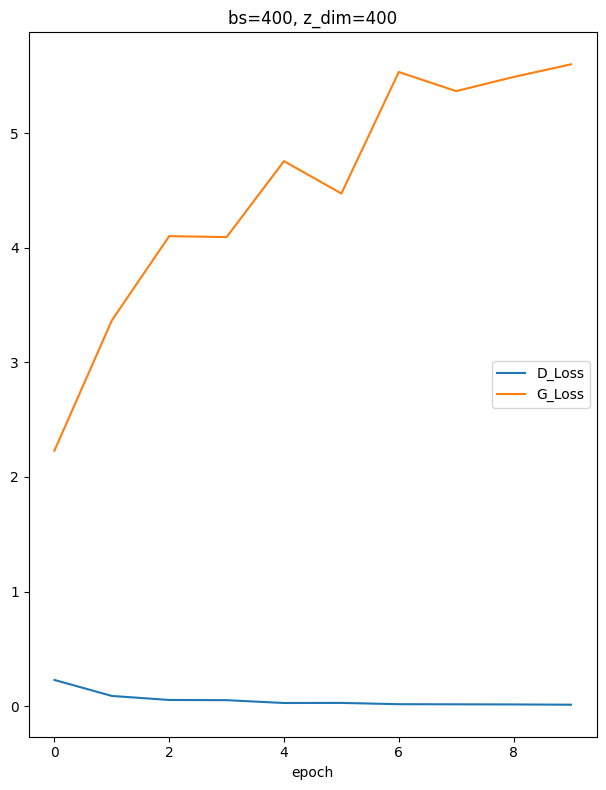

bs=400, z_dim=400
	D_Loss           	 (min:    0.013, max:    0.229, cur:    0.013)
	G_Loss           	 (min:    2.230, max:    5.601, cur:    5.601)


In [ ]:
## COMMENT: bs=400, z_dim=400, it's getting bette, but not enough

# define train data
bs = 400
train_dataset = XrayDataset(root_dir='/content/gdrive/MyDrive/real_hands', transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)

# define G and D
image_size=32
z_dim = 400

G = Generator(image_size=image_size, z_dim=z_dim).to(device)
D = Discriminator(image_size=image_size).to(device)

# define loss functions and optimizer
criterion = nn.BCELoss()
lr = 0.00005

G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)

n_epoch = 10
groups = {'bs=400, z_dim=400': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epoch+1):
  D_losses, G_losses = [], []
  logs = {}
  for batch_idx, (x, _) in enumerate(train_loader):
    logs['D_Loss'] = D_train(x)
    logs['G_Loss'] = G_train(x)
  liveloss.update(logs)
  liveloss.draw()

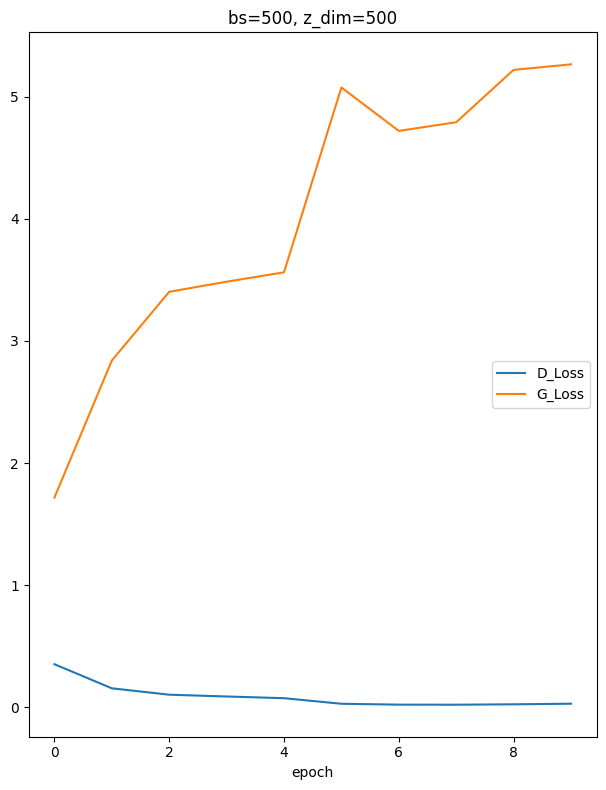

bs=500, z_dim=500
	D_Loss           	 (min:    0.021, max:    0.352, cur:    0.029)
	G_Loss           	 (min:    1.717, max:    5.266, cur:    5.266)


In [ ]:
## COMMENT: bs=500, z_dim=500, it's getting bette, but not enough

# define train data
bs = 500
train_dataset = XrayDataset(root_dir='/content/gdrive/MyDrive/real_hands', transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)

# define G and D
image_size=32
z_dim = 500

G = Generator(image_size=image_size, z_dim=z_dim).to(device)
D = Discriminator(image_size=image_size).to(device)

# define loss functions and optimizer
criterion = nn.BCELoss()
lr = 0.00005

G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)

n_epoch = 10
groups = {'bs=500, z_dim=500': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epoch+1):
  D_losses, G_losses = [], []
  logs = {}
  for batch_idx, (x, _) in enumerate(train_loader):
    logs['D_Loss'] = D_train(x)
    logs['G_Loss'] = G_train(x)
  liveloss.update(logs)
  liveloss.draw()

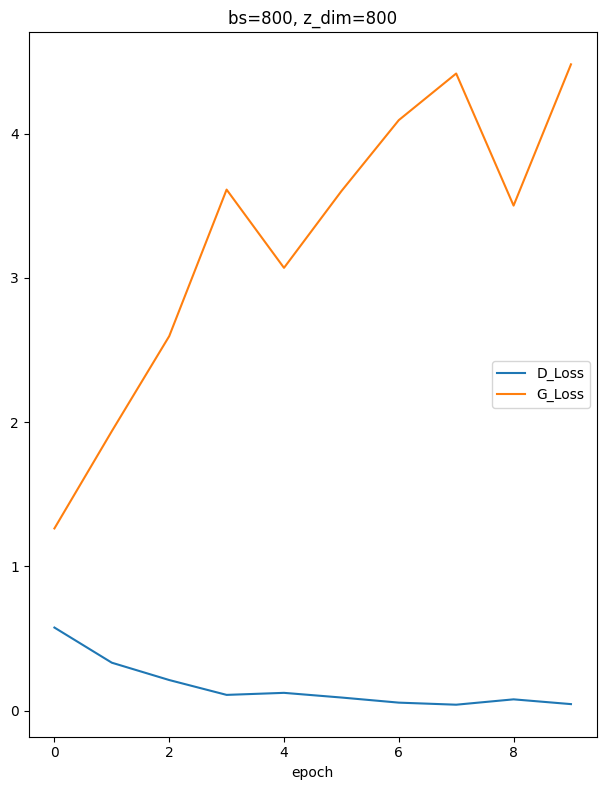

bs=800, z_dim=800
	D_Loss           	 (min:    0.042, max:    0.576, cur:    0.046)
	G_Loss           	 (min:    1.263, max:    4.479, cur:    4.479)


In [ ]:
## COMMENT: bs=800, z_dim=800 give by far the best parameters

# define train data
bs = 800
train_dataset = XrayDataset(root_dir='/content/gdrive/MyDrive/real_hands', transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)

# define G and D
image_size=32
z_dim = 800

G = Generator(image_size=image_size, z_dim=z_dim).to(device)
D = Discriminator(image_size=image_size).to(device)

# define loss functions and optimizer
criterion = nn.BCELoss()
lr = 0.00005

G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)

n_epoch = 10
groups = {'bs=800, z_dim=800': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epoch+1):
  D_losses, G_losses = [], []
  logs = {}
  for batch_idx, (x, _) in enumerate(train_loader):
    logs['D_Loss'] = D_train(x)
    logs['G_Loss'] = G_train(x)
  liveloss.update(logs)
  liveloss.draw()

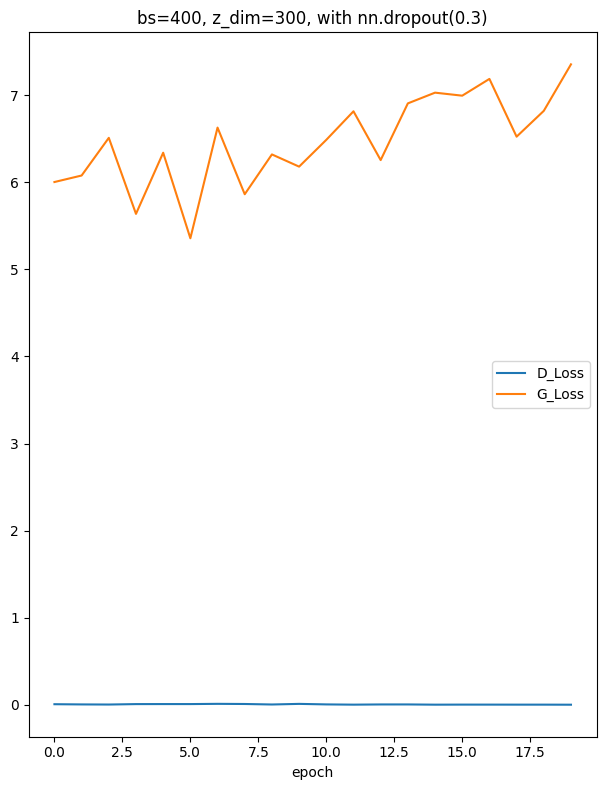

bs=400, z_dim=300, with nn.dropout(0.3)
	D_Loss           	 (min:    0.001, max:    0.011, cur:    0.001)
	G_Loss           	 (min:    5.357, max:    7.354, cur:    7.354)


In [ ]:
## COMMENT: dropout doesn't help improving my structure

n_epoch = 20
groups = {'bs=400, z_dim=300, with nn.dropout(0.3)': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epoch+1):
  D_losses, G_losses = [], []
  logs = {}
  for batch_idx, (x, _) in enumerate(train_loader):
    logs['D_Loss'] = D_train(x)
    logs['G_Loss'] = G_train(x)
  liveloss.update(logs)
  liveloss.draw()

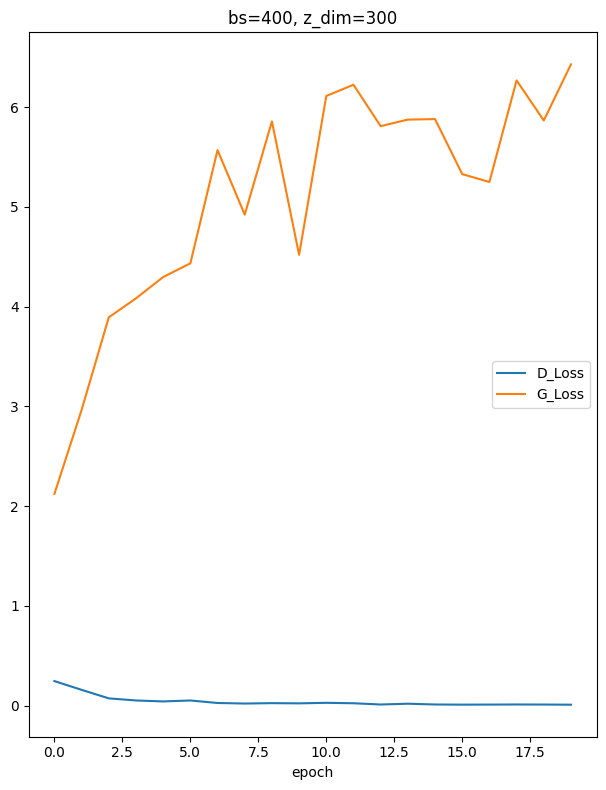

bs=400, z_dim=300
	D_Loss           	 (min:    0.009, max:    0.246, cur:    0.009)
	G_Loss           	 (min:    2.123, max:    6.430, cur:    6.430)


In [ ]:
## COMMENT: replace ReLU with leaky_relu helps my structure

n_epoch = 20
groups = {'bs=400, z_dim=300': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epoch+1):
  D_losses, G_losses = [], []
  logs = {}
  for batch_idx, (x, _) in enumerate(train_loader):
    logs['D_Loss'] = D_train(x)
    logs['G_Loss'] = G_train(x)
  liveloss.update(logs)
  liveloss.draw()

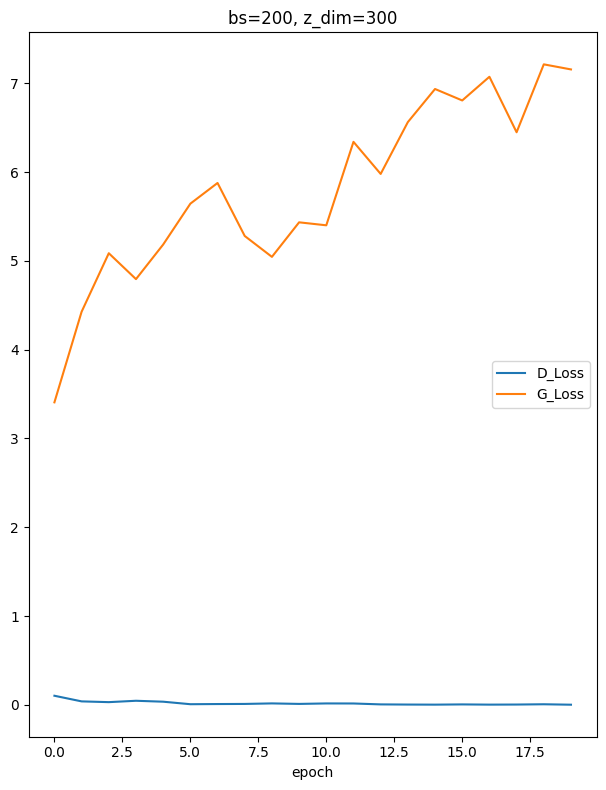

bs=200, z_dim=300
	D_Loss           	 (min:    0.001, max:    0.102, cur:    0.001)
	G_Loss           	 (min:    3.407, max:    7.214, cur:    7.157)


In [ ]:
n_epoch = 20
groups = {'bs=200, z_dim=300': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epoch+1):
  D_losses, G_losses = [], []
  logs = {}
  for batch_idx, (x, _) in enumerate(train_loader):
    logs['D_Loss'] = D_train(x)
    logs['G_Loss'] = G_train(x)
  liveloss.update(logs)
  liveloss.draw()

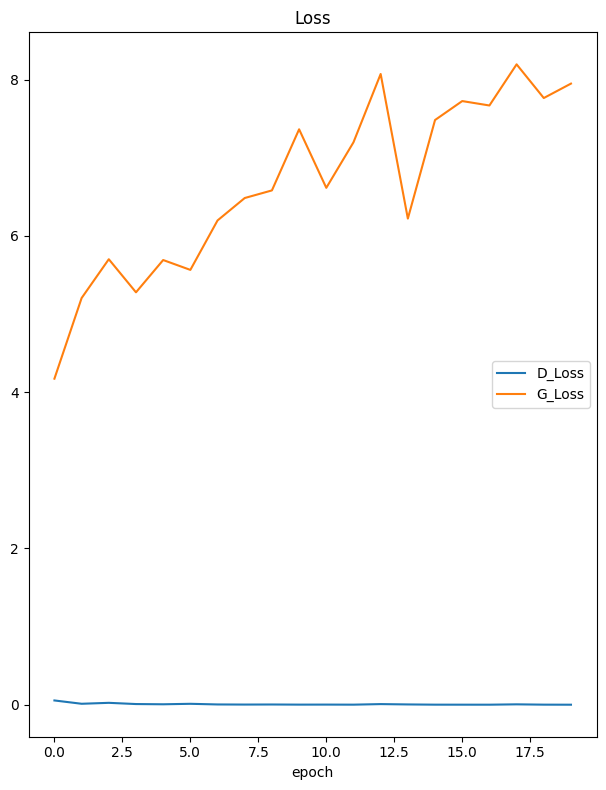

Loss
	D_Loss           	 (min:    0.000, max:    0.055, cur:    0.000)
	G_Loss           	 (min:    4.172, max:    8.195, cur:    7.948)


In [ ]:
# batch size=100, z_dim=300

n_epoch = 20
groups = {'Loss': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epoch+1):
  D_losses, G_losses = [], []
  logs = {}
  for batch_idx, (x, _) in enumerate(train_loader):
    logs['D_Loss'] = D_train(x)
    logs['G_Loss'] = G_train(x)
  liveloss.update(logs)
  liveloss.draw()

# I chose bs=800, z_dim=800, lr=0.00005, using leaky_relu and use convolutional layers for my model, the reasons are described above